# TWEET STANCE CLASSIFIER

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from transformers import modelcard

from models.transfomer_stance_classifier import StanceClassifier

/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebre

In [2]:
EPOCH = 3

# Helper functions

In [3]:
def plot_history(history):
    plt.plot(history.Epoch, history["Training Loss"], label='train_loss')
    plt.plot(history.Epoch, history["Validation Loss"], label='val_loss')

    plt.legend()
    plt.xticks(history.Epoch)
    plt.xlabel('Epoch')
    plt.ylabel("loss")
    plt.grid(True)

In [4]:
def evaluate(test_stances, test_targets, test_preds, model_name):
    df = pd.DataFrame({"Stance": test_stances, "Target": test_targets, "preds": test_preds})

    f1_per_stance = f1_score(test_stances, test_preds, average=None)

    metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()

    for stance, f1 in zip(["AGAINST", "FAVOR", "NONE"], f1_per_stance):
        metrics[stance] = f1

    metrics["overall"] = f1_score(test_stances, test_preds, average="macro")
    
    return pd.DataFrame(metrics, index=[model_name])

In [5]:
def plot_confusion_matrix(test_stances, test_preds, class_names=["AGAINST", "FAVOR", "NONE"], 
                          title="Confusion Matrix for Stance Detection\n\n"):
    cf_matrix = confusion_matrix(test_stances, test_preds)
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.0f')

    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');

    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [6]:
def print_report(classifier, test_texts, test_targets, test_stances, model_name, 
                 class_names=["AGAINST", "FAVOR", "NONE"], cm_title="Confusion Matrix for Stance Detection\n\n"):
    history = pd.DataFrame(modelcard.parse_log_history(classifier.trainer.state.log_history)[1])
    plot_history(history)
    
    preds = pd.DataFrame(classifier.predict(test_texts, test_targets)).label.str.split("_").str[1].astype(int)
    eval_df = evaluate(test_stances, test_targets, preds, model_name)
    display(eval_df)
    
    plot_confusion_matrix(test_stances, preds)
    
    return eval_df

## Data Overview

In [7]:
train_dir = 'data/StanceDataset/train.csv'
test_dir = 'data/StanceDataset/test.csv'

# train_dir = 'data/processed_train.csv'
# test_dir = 'data/processed_test.csv'

In [8]:
from charset_normalizer import detect
# Detect the encoding
with open(train_dir, "rb") as f:
    detected_encoding = detect(f.read())["encoding"]

In [9]:
train_df = pd.read_csv(train_dir, encoding=detected_encoding, engine='python', on_bad_lines='skip')
test_df = pd.read_csv(test_dir, encoding=detected_encoding, engine='python', on_bad_lines='skip')

In [10]:
train_df.columns

Index(['Tweet', 'Target', 'Stance', 'Opinion Towards', 'Sentiment'], dtype='object')

In [11]:
train_df, val_df = train_test_split(train_df, random_state=42)

In [12]:
train_df.reset_index(inplace=True)

In [13]:
val_df.reset_index(inplace=True)

## Data Preprocess 

In [14]:
stance_map = {'FAVOR': 0, 'AGAINST': 1, 'NONE': 2}

In [15]:
train_texts = train_df['Tweet']
train_targets = train_df['Target']
train_stances = train_df['Stance'].map(stance_map)

In [16]:
test_texts = test_df['Tweet']
test_targets = test_df['Target']
test_stances = test_df['Stance'].map(stance_map)

In [17]:
val_texts = val_df['Tweet']
val_targets = val_df['Target']
val_stances = val_df['Stance'].map(stance_map)

## Modelling

### roberta-base

In [18]:
MODEL_NAME_1 = "roberta-base"

In [19]:
classifier = StanceClassifier(MODEL_NAME_1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
    num_epochs=EPOCH,
    output_dir=f"./stance_model/{MODEL_NAME_1}"
)

Epoch,Training Loss,Validation Loss,F1
1,0.964700,0.901137,0.541986
2,0.770800,0.786044,0.644138
3,0.559400,0.777073,0.674608


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_50964/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
roberta-base,0.598116,0.616876,0.366254,0.582509,0.510482,0.590158,0.496984,0.671771,0.564057,0.577604


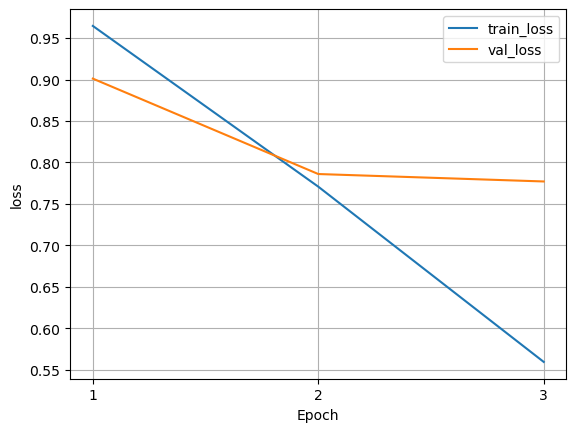

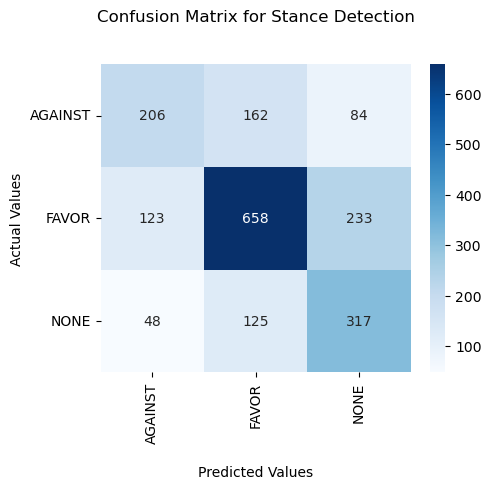

In [21]:
eval_df1 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_1)

### bertweet

In [22]:
MODEL_NAME_2 = "vinai/bertweet-base"

In [23]:
classifier = StanceClassifier(MODEL_NAME_2)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
    num_epochs=EPOCH,
    output_dir=f"./stance_model/{MODEL_NAME_2}"
)

Epoch,Training Loss,Validation Loss,F1
1,0.958600,0.822630,0.597830
2,0.699000,0.736990,0.674143
3,0.496800,0.735414,0.708403


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_50964/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
vinai/bertweet-base,0.611082,0.571221,0.346229,0.582042,0.69454,0.616713,0.53911,0.658051,0.588235,0.595132


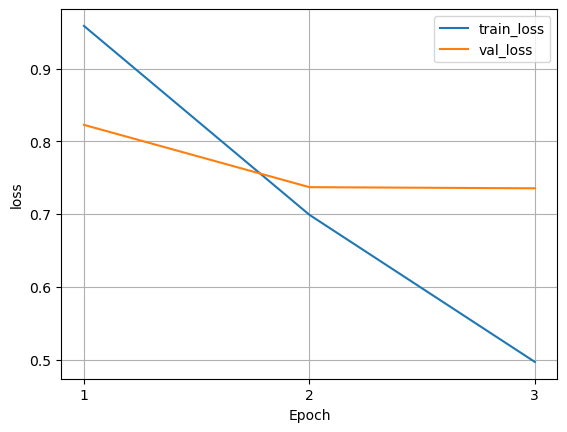

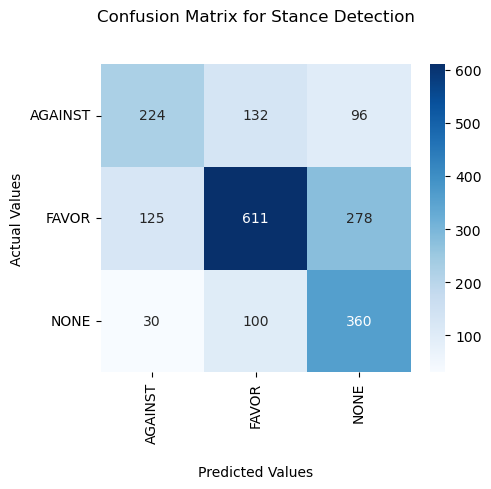

In [25]:
eval_df2 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_2)

### bert-base-uncased

In [26]:
MODEL_NAME_3 = "bert-base-uncased"

In [27]:
classifier = StanceClassifier(MODEL_NAME_3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
    num_epochs=EPOCH,
    output_dir=f"./stance_model/{MODEL_NAME_3}"
)

Epoch,Training Loss,Validation Loss,F1
1,0.942900,0.844423,0.549750
2,0.727000,0.776548,0.662781
3,0.485100,0.788408,0.673469


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_50964/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
bert-base-uncased,0.620401,0.576988,0.28122,0.540276,0.637369,0.552533,0.5086,0.633296,0.545455,0.56245


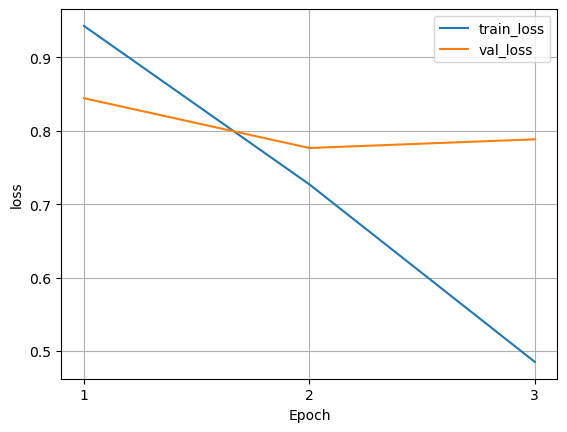

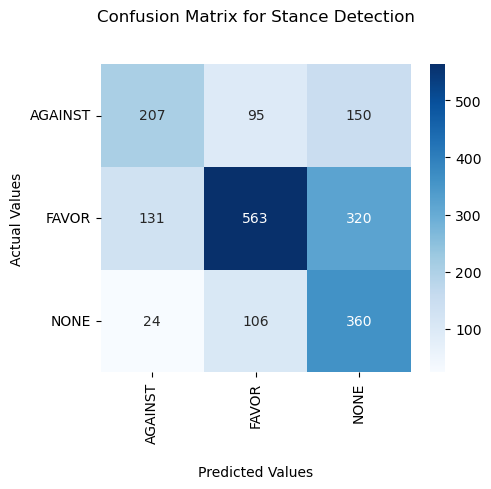

In [29]:
eval_df3 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_3)

### distilbert-base-cased

In [30]:
MODEL_NAME_4 = "distilbert-base-cased"

In [31]:
classifier = StanceClassifier(MODEL_NAME_4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
classifier.train(
    train_texts= train_texts,
    train_targets=train_targets,
    train_stances=train_stances,
    val_texts = val_texts,
    val_targets=val_targets,
    val_stances=val_stances,
    num_epochs=EPOCH,
    output_dir=f"./stance_model/{MODEL_NAME_4}"
)

Epoch,Training Loss,Validation Loss,F1
1,0.939000,0.822981,0.600982
2,0.666800,0.758401,0.650897
3,0.405700,0.836318,0.674513


Device set to use mps:0
/var/folders/59/y8807kwj75nfp1r9n0zrnk7h0000gn/T/ipykernel_50964/19166642.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby("Target").apply(lambda row: f1_score(row["Stance"], row["preds"], average="macro")).to_dict()


,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
distilbert-base-cased,0.538773,0.505683,0.342466,0.554177,0.593528,0.565991,0.480094,0.651258,0.511251,0.547534


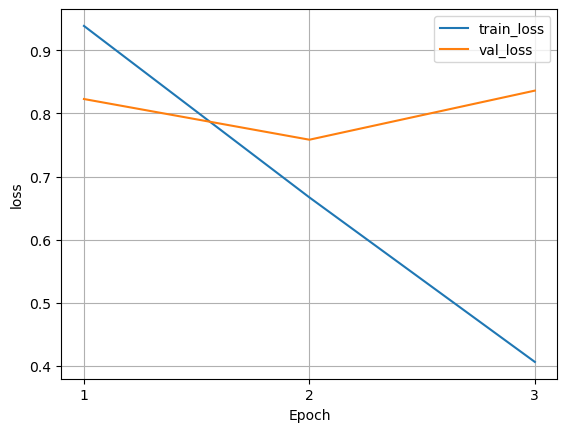

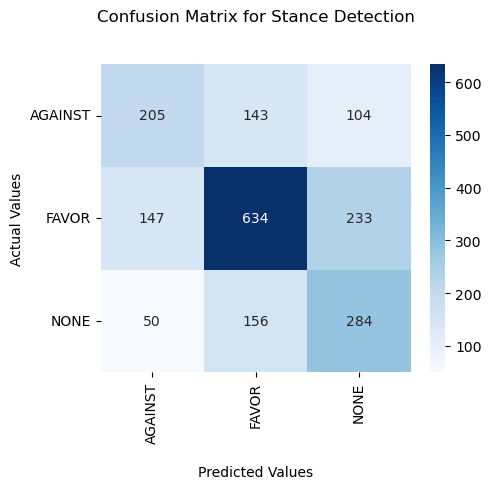

In [33]:
eval_df4 = print_report(classifier, test_texts, test_targets, test_stances, MODEL_NAME_4)

In [34]:
pd.concat([eval_df1, eval_df2, eval_df3, eval_df4])

,Atheism,Climate Change is a Real Concern,Donald Trump,Feminist Movement,Hillary Clinton,Legalization of Abortion,AGAINST,FAVOR,NONE,overall
roberta-base,0.598116,0.616876,0.366254,0.582509,0.510482,0.590158,0.496984,0.671771,0.564057,0.577604
vinai/bertweet-base,0.611082,0.571221,0.346229,0.582042,0.694540,0.616713,0.539110,0.658051,0.588235,0.595132
bert-base-uncased,0.620401,0.576988,0.281220,0.540276,0.637369,0.552533,0.508600,0.633296,0.545455,0.562450
distilbert-base-cased,0.538773,0.505683,0.342466,0.554177,0.593528,0.565991,0.480094,0.651258,0.511251,0.547534
